<h1>Notation</h1>
<ul>
    <li>F - State Transition Matrix</li>
    <li>G - Process Noise Transformation</li>
    <li>H - Observation Matrix(State Tracks more variables than what is measured)</li>
    <li>R - Measurement Noise Covariance</li>
    <li>Q - Process Noise Covariance</li>
    <li>x0,P - Initial state and state covariance</li>
    <li> C - Weighted Adjacencey Matrix</li>
</ul>

In [31]:
import numpy as np

class Node:
    def __init__(self,id,F,G,H,R,Q,x0,P):
        self.id = id
        self.F = F
        self.G = G
        self.H = H
        self.R = R
        self.Q = Q

        #Has an instance for each node
        self.x = x0
        
        self.P = P

        self.nbhrs = []
        self.nbhr_weights = {}

        self.psi = np.zeros(x0.shape)
        self.HRH = self.H.T@np.linalg.inv(self.R)@self.H
        self.HRq = lambda y: self.H.T@np.linalg.inv(self.R)@y
    
    def predict(self):
        self.x = self.F@(np.sum([self.nbhr_weights[node.id]*node.psi for i,node in enumerate(self.nbhrs)],0))
        self.P = (self.F@self.P@self.F.T) + (self.G@self.Q@self.G.T)

    def update(self, y):
        S = np.sum([node.HRH for node in self.nbhrs],0)
        q = np.sum([node.HRq(y) for node in self.nbhrs],0)
        self.P = np.linalg.inv(np.linalg.inv(self.P) + S)
        self.psi = self.x+(self.P@(q - (S@self.x)))

class DiffKF:
    def __init__(self,C,F,G,H,R,Q,x0,P):
        
        #Number of nodes
        self.n = len(x0)

        #weighted adjacencey matrix, nodes must be connected to themselves
        self.C = C

        #Has an instance for each node
        self.nodes = []
        for i in range(self.n):
            self.nodes.append(Node(i,F[i],G[i],H[i],R[i],Q[i],x0[i],P[i]))
        
        for i in range(self.n):
            for j in range(self.n):
                if self.C[i][j] != 0:
                    self.nodes[i].nbhrs.append(self.nodes[j])
                    self.nodes[i].nbhr_weights[j] = C[i][j]
    
    def predict(self): #a.k.a diffusion update
        result = []
        for node in self.nodes:
            node.predict()
            result.append(node.x)
        
        return result
        
    
    def update(self, y): #a.k.a Incremental update
        for i,node in enumerate(self.nodes):
            node.update(y[i])

<h1>Example Description</h1>
<p>We have an object moving in the plane and our state(x) is it's position, velocity, and acceleration in the x and y directions. We have 4 nodes in a square/loop which each get measurements of the location every second with different noise. They communicate with their neighbors and weigh estimates equally*(33/100 from two neighbor estimates and 34/100 for personal estimate)</p>
<p>The plots show the Estimates vs Measurements of each of the four nodes and then a convergence plot that averages the error from each of the four nodes.</p>

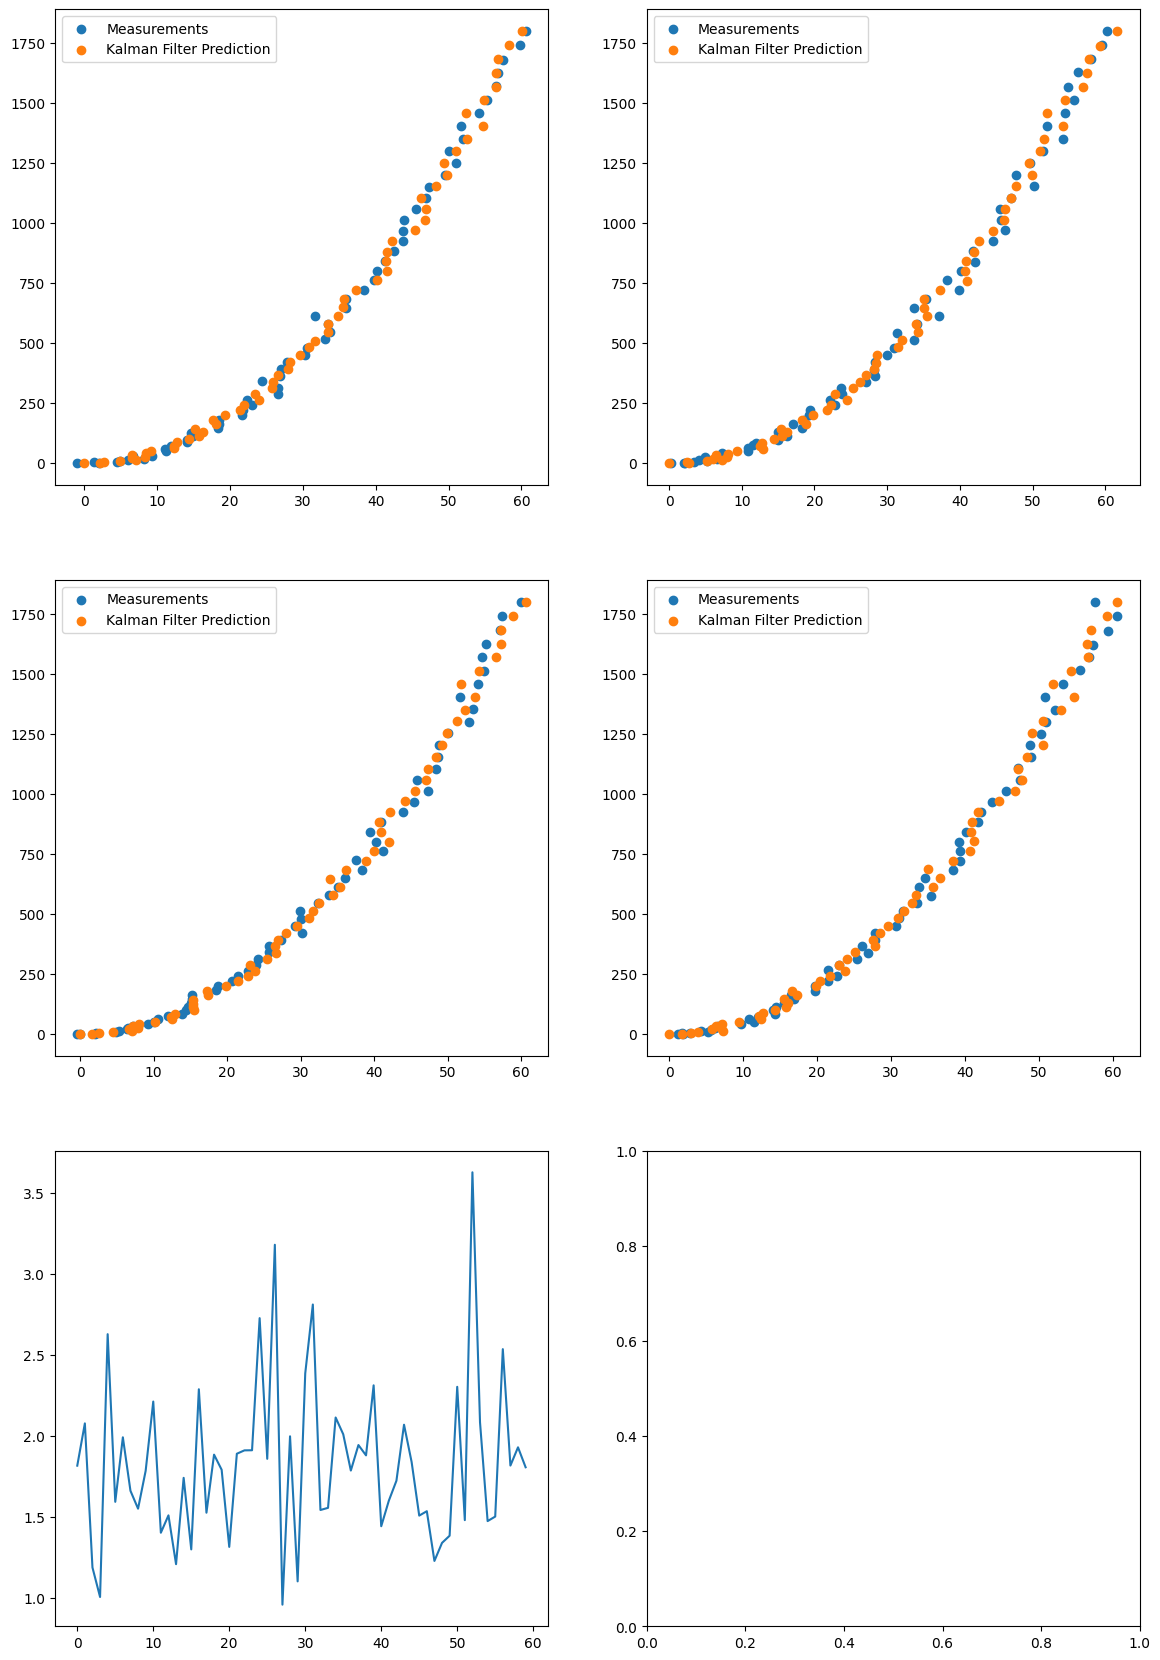

In [56]:
import matplotlib.pyplot as plt
np.random.seed(163)
def example():
    C = np.array([[0.34,0.33,0.33,0],[0.33,0.34,0,0.33],[0.33,0,0.34,0.33],[0,0.33,0.33,0.34]])
    n = len(C[0])

    F = [np.array([[1, 1, 0.5, 0, 0, 0], [0, 1, 1, 0, 0, 0],[0,0,1,0,0,0], [0, 0, 0, 1, 1, 0.5], [0,0,0,0,1,1],[0,0,0,0,0,1]]) for _ in range(n)]
    G = [np.eye(6) for _ in range(n)]
    H = [np.array([[1, 0, 0, 0, 0, 0],[0,0,0,1,0,0]]) for _ in range(n)]

    Q = [np.array([[0.05, 0, 0, 0, 0, 0], [0, 0.05, 0, 0, 0, 0],[0,0,0.05,0,0,0], [0, 0, 0, 0.05, 0, 0], [0,0,0,0,0.05,0],[0,0,0,0,0,0.05]]) for _ in range(n)]
    R = [np.array([[1,0],[0,1]]) for _ in range(n)]

    #This is the true starting value that we update to get true values
    xp = np.array([[0,1,0,0,0,1]]).T

    #These are random first estimates for each of the nodes
    x0 = [np.array([[np.random.normal(0,5) for _ in range(6)]]).T for k in range(n)]
    
    P = [np.eye(6) for _ in range(n)]


    DKF = DiffKF(C,F,G,H,R,Q,x0,P)

    
    measure_var = 1
    z = [(H[0] @ xp)+np.random.normal([[0],[0]],measure_var, (2,1)) for _ in range(n)]

    truth = [F[0]@xp]
    predictions = {i:[] for i in range(n)}
    measurements = [z]
    errors = []
    for i in range(60):
        x = DKF.predict()
        for j in range(n):
            predictions[j].append(H[j]@x[j])
        z = [(H[0] @ truth[-1])+np.random.normal([[0],[0]],measure_var, (2,1)) for _ in range(n)]
        truth.append(F[0]@truth[-1])
        measurements.append(z)
        errors.append(np.average([np.linalg.norm((H[j]@x[j])-z[j]) for j in range(n)]))
        DKF.update(z)

    fig,axs = plt.subplots(((n+2)//2),2, figsize=(14, 7*((n+2)//2)))
    for i in range(n):
        axs[i//2][i%2].scatter([x[i][0][0] for x in measurements],[x[i][1][0] for x in measurements], label = 'Measurements')
        axs[i//2][i%2].scatter([x[0][0] for x in predictions[i]],[x[1][0] for x in predictions[i]], label = 'Kalman Filter Prediction')
        # axs[i//2][i%2].scatter([(H[i]@x)[0][0] for x in truth],[(H[i]@x)[1][0] for x in truth], label = 'True Values')
        axs[i//2][i%2].legend()
    axs[n//2][n%2].plot([i for i in range(len(errors))],errors, label = 'Prediction vs Truth Error')
    plt.show()

example()

    